In [1]:
include("model_2D_IB.jl")

using SparseIR, Plots
#using OMEinsum
#using FastGaussQuadrature
import SparseIR: valueim, value
import SparseIR: fit

In [2]:
struct IR_params
    U::Float64
    beta::Float64
    bw::Float64
    basis::FiniteTempBasis
    #{Fermionic, LogisticKernel, Float64, Float64}
    
    smpl_matsu::MatsubaraSampling64F
    smpl_tau::TauSampling64

    n_matsu::Int
    n_tau::Int

    smpl_wn::Vector{ComplexF64}
end

function set_IR(U::Float64, beta::Float64, bw::Float64)
    basis = FiniteTempBasis(Fermionic(), beta, bw, 1e-10)

    smpl_matsu = MatsubaraSampling(basis)
    n_matsu = size(smpl_matsu.sampling_points)[1]

    smpl_tau = TauSampling(basis)
    n_tau = size(smpl_tau.sampling_points)[1]

    smpl_wn = zeros(ComplexF64, n_matsu)
    for w in 1:n_matsu
        smpl_wn[w] = valueim(smpl_matsu.sampling_points[w], beta)
    end

    return U, beta, bw, basis, smpl_matsu, smpl_tau, n_matsu, n_tau, smpl_wn
end

mutable struct Green_Sigma
    g0_ir::Vector{Matrix{ComplexF64}}
    g0_ir_vec::Matrix{Float64}
    g0_tau::Vector{Matrix{ComplexF64}}
    g_tau::Vector{Matrix{ComplexF64}}
    g0_matsu::Vector{Matrix{ComplexF64}}

    g_ir::Vector{Matrix{ComplexF64}}
    g_ir_vec::Matrix{Float64}
    g_matsu::Vector{Matrix{ComplexF64}}

    sigma_ir::Vector{Matrix{ComplexF64}}
    sigma_tau::Vector{Matrix{ComplexF64}}
    sigma_matsu::Vector{Matrix{ComplexF64}}

    n_ir::Int
end

function init_zero_g(ir::IR_params)
    
    g0_ir::Vector{Matrix{ComplexF64}} = []
    g0_ir_vec = zeros(Float64, 43, 4)
    g0_tau::Vector{Matrix{ComplexF64}} = []
    g_tau::Vector{Matrix{ComplexF64}} = []
    g0_matsu::Vector{Matrix{ComplexF64}} = []

    g_ir::Vector{Matrix{ComplexF64}} = []
    g_ir_vec = zeros(Float64, 43, 4)
    g_matsu::Vector{Matrix{ComplexF64}} = []

    sigma_ir::Vector{Matrix{ComplexF64}} = []
    sigma_tau::Vector{Matrix{ComplexF64}} = []
    sigma_matsu::Vector{Matrix{ComplexF64}} = []

    n_ir::Int = 0

    return g0_ir, g0_ir_vec, g0_tau, g_tau, g0_matsu, g_ir, g_ir_vec, g_matsu, sigma_ir, sigma_tau, sigma_matsu, n_ir
end


function gk_m(p::Parm, k::Vector{Float64}, w::ComplexF64, g::Green_Sigma)
    e = set_H(k,p)
    gk = 1.0/(w - e - g.sig)
    return gk
end


gk_m (generic function with 1 method)

In [3]:
#t_i, t_b, Δ, mu0, eta, K_SIZE
px = Parm(set_parm(["0.5","0.2","0.005", "-2.0", "0.05", "200"])...)
#U, beta, bw
irx = IR_params(set_IR(4.0, 100.0, 3.0)...)
println(px)


Parm(0.5, 0.2, 0.005, -2.0, 0.05, 200, 2.5e-5)


In [4]:
#gx = Green_Sigma(init_zero_g(irx)...)
kk = get_kk(px.K_SIZE)
println("gx")

gx


In [16]:

function get_G0mlocal!(p::Parm, k_BZ::Vector{Vector{Float64}}, sw::Int,ir::IR_params, g::Green_Sigma)
    if(sw == 1)
        for wn in 1:ir.n_matsu
            gw_l = zeros(ComplexF64, 2, 2)
            gl = zeros(ComplexF64, 2, 2)
            for i in 1:length(k_BZ)
                e = set_H(k_BZ[i],p) - p.mu*sigma[1]
                #gk = 1.0/(w - e + p.eta*1.0im*sign(imag(w)))
                gk = inv(ir.smpl_wn[wn]*sigma[1] - e)
                gw_l += p.dk2 * gk
            end
            push!(g.g0_matsu, gw_l)
            push!(g.g_matsu, gl)
        end
    else
        if(sw==2)
            n_sub = -sigma[2]*g.g0_tau[end]*sigma[2]
        else
            n_sub = -sigma[2]*g.g_tau[end]*sigma[2]
        end
        #n_sub = -(sigma[2]*g.g0_tau[1]*sigma[2])
        n_re = real(n_sub[1,1]+n_sub[2,2])
        n_sub = n_sub ./ n_re
        for wn in 1:ir.n_matsu
            #gw_l = zeros(ComplexF64, 2, 2)
            gl = zeros(ComplexF64, 2, 2)
            for i in 1:length(k_BZ)
                #e = set_H(k_BZ[i],p) - p.mu*Matrix{Complex{Float64}}(I,2,2) - p.Δ*sigma[4]
                #gk = 1.0/(w - e + p.eta*1.0im*sign(imag(w)))
                #e = set_H(k_BZ[i],p) - p.Δ*sigma[4]
                e = set_H(k_BZ[i],p) - p.Δ*sigma[4]
                #gk = inv(ir.smpl_wn[wn]*sigma[1] - e - g.sigma_matsu[wn]- ir.U * n_sub)
                gk = inv(ir.smpl_wn[wn]*sigma[1] - e - g.sigma_matsu[wn] -ir.U * n_sub)
                #gk = inv(ir.smpl_wn[wn]*sigma[1] - e- ir.U * n_sub)
                #gk = inv(ir.smpl_wn[wn]*sigma[1] - e)
                gl += p.dk2 * gk
            end
            #gw_l = inv(inv(gl) + g.sigma_matsu[wn])
            #g.g0_matsu[wn] = gw_l
            g.g_matsu[wn] = gl
        end
        #println("n_sum:$(n_re), n_sub11:$(real(n_sub[1,1])), n_sub11:$(real(n_sub[2,2]))")
        for wn in 1:ir.n_matsu
            g.g0_matsu[wn] = inv(inv(g.g_matsu[wn]) + g.sigma_matsu[wn])
            #g.g0_matsu[wn] = inv(inv(g.g_matsu[wn])) 
        end
        #println(g.sigma_matsu[10])
    end
    return nothing
end

get_G0mlocal! (generic function with 1 method)

In [6]:
function MatsuToTau!(ir::IR_params, g::Green_Sigma)
    g.g0_ir = fit(ir.smpl_matsu, g.g0_matsu, dim=1)
    g.g_ir = fit(ir.smpl_matsu, g.g_matsu, dim=1)
    g.n_ir = size(g.g0_ir)[1]
    g.g0_tau = evaluate(ir.smpl_tau, g.g0_ir, dim=1)
    g.g_tau = evaluate(ir.smpl_tau, g.g_ir, dim=1)
end

MatsuToTau! (generic function with 1 method)

In [31]:
get_G0mlocal!(px, kk, 1, irx, gx)

In [32]:
MatsuToTau!(irx, gx)
println("done!")

done!


In [7]:
function calc_sigma!(sw::Int, ir::IR_params, g::Green_Sigma)
    for tau in 1:ir.n_tau
        if(sw == 1)
            test = zeros(ComplexF64, 2, 2)
            for i in 1:2, j in 1:2 
                test[i,j] = ir.U^2 * (g.g0_tau[tau])[i,j] * (g.g0_tau[tau])[3-i,3-j] * (g.g0_tau[end+1-tau])[3-i,3-j]
                #test[i,j] += -ir.U * (g.g0_tau[1])[3-i,3-j]
            end
            push!(g.sigma_tau, test)
        else
            for i in 1:2, j in 1:2 
                (g.sigma_tau[tau])[i,j] = ir.U^2 * (g.g0_tau[tau])[i,j] * (g.g0_tau[tau])[3-i,3-j] * (g.g0_tau[end+1-tau])[3-i,3-j]
                #(g.sigma_tau[tau])[i,j] += -ir.U * (g.g0_tau[1])[3-i,3-j]
                #(g.sigma_tau[tau])[i,j] = ir.U^2 * (g.g0_tau[tau])[i,j] * (g.g0_tau[tau])[i,j] * (g.g0_tau[end+1-tau])[i,j]
            end
        end
    end
    #println("Sigma1:$((gx.sigma_tau[1])[1,1])")
    #println("Sigma2:$((gx.sigma_tau[1])[2,2])")
    return nothing
end

calc_sigma! (generic function with 1 method)

In [8]:
function TauToMatsu!(sw::Int, ir::IR_params, g::Green_Sigma, γ::Float64)
    ir_new = fit(ir.smpl_tau, g.sigma_tau)
    diff0 =0.0
    sum0 = 0.0
    if(sw == 1)
        for i in 1:g.n_ir
            diff0 += sum(abs.(ir_new[i]))
            push!(g.sigma_ir, zeros(ComplexF64, 2, 2))
        end
        sum0 = 1.0
    else
        for i in 1:g.n_ir
            diff0 += sum(abs.(ir_new[i] .- g.sigma_ir[i]))
            sum0 += sum(abs.(g.sigma_ir[i]))
        end
    end
    diff = diff0/sum0
    g.sigma_ir = (1.0-γ) .* g.sigma_ir .+ γ .* ir_new
    g.sigma_matsu = evaluate(ir.smpl_matsu, g.sigma_ir, dim=1)

    return diff
end

TauToMatsu! (generic function with 1 method)

In [9]:
function update_g!(p::Parm, k_BZ::Vector{Vector{Float64}},sw::Int, ir::IR_params, g::Green_Sigma, γ::Float64)
    get_G0mlocal!(p, k_BZ, sw, ir, g)
    MatsuToTau!(ir, g)
    calc_sigma!(sw, ir, g)
    # .+ ir.U .* g.g0_tau
    diff = TauToMatsu!(sw, ir, g, γ)
    return diff
end

update_g! (generic function with 1 method)

In [10]:
px = Parm(set_parm(["0.5","0.2","0.3", "-1.0", "0.05", "200"])...)

Parm(0.5, 0.2, 0.3, -1.0, 0.05, 200, 2.5e-5)

In [21]:
w_size= 1001
w_mesh = range(-4.0,1.0, length=w_size)
dw = w_mesh[2]-w_mesh[1]
GR_l = zeros(ComplexF64, w_size, 2, 2)
n_l = zeros(Float64, 2)
f(ww,bb) = 1.0/(1.0+exp(bb*ww))
for id_k in 1:size(kk)[1]
    e = set_H(kk[id_k], px) - px.mu*sigma[1]
    for id_w in 1:w_size
        Gr0 = (w_mesh[id_w]+ 1.0im*px.eta)*sigma[1] - e
        GR_l[id_w,:,:] += px.dk2*inv(Gr0) 
    end
end
for id_w in 1:w_size
    n_l[1] += -dw*imag(GR_l[id_w,1,1])/pi * f(w_mesh[id_w], irx.beta)
    n_l[2] += -dw*imag(GR_l[id_w,2,2])/pi * f(w_mesh[id_w], irx.beta)
end

println(n_l)


[0.30542399464291814, 0.686295027250638]


In [17]:
gx = Green_Sigma(init_zero_g(irx)...)
for it in 1:1000
    L1 = update_g!(px,kk,it,irx,gx, 0.2)
    if(L1<1e-7)
        println(it)
        break
    end
end

In [18]:
function MtoV(MM::Vector{Matrix{ComplexF64}})
    l = size(MM)[1]
    VV = zeros(ComplexF64, l, 4)
    for it in 1:l
        for mm in 1:4
            VV[it,mm] = tr(sigma[mm]*MM[it])/2
        end
    end
    return VV
end

MtoV (generic function with 1 method)

In [60]:
ss = MtoV(gx.sigma_matsu)

44×4 Matrix{ComplexF64}:
  1.46755e-15+0.0152074im  …  -0.000288675+2.28116e-16im
  -1.2503e-15+0.0458025im      -0.00263735+6.93889e-18im
 -6.77843e-16+0.0765407im      -0.00747604+4.85723e-16im
 -8.62158e-16+0.107371im        -0.0150736-4.16334e-17im
  1.23165e-16+0.13801im         -0.0258223-6.93889e-17im
  6.93889e-17+0.16614im    …    -0.0392834+2.22045e-16im
  3.33067e-16+0.191418im        -0.0556055+2.22045e-16im
  1.17961e-16+0.211045im        -0.0728782-2.77556e-17im
    2.498e-16+0.227254im        -0.0936065-2.08167e-16im
  4.85723e-16+0.23735im          -0.116682+4.16334e-17im
  1.80411e-16+0.239791im   …     -0.133684+1.11022e-16im
  1.70697e-15+0.237229im         -0.153361+1.94289e-16im
  1.45717e-15+0.231251im         -0.168004-8.60423e-16im
             ⋮             ⋱  
  1.94289e-15-0.237229im         -0.153361+8.74301e-16im
  6.10623e-16-0.239791im         -0.133684+9.71445e-16im
  7.97973e-16-0.23735im          -0.116682+1.05471e-15im
  8.25728e-16-0.227254im   …    

In [19]:
plot(imag.(ss[:,1]))
plot!(real.(ss[:,4]))
plot!(imag.(ss[:,4]))

LoadError: UndefVarError: ss not defined

In [20]:
function MtoV!(g::Green_Sigma)
    g.g0_ir_vec = zeros(Float64, g.n_ir, 4)
    g.g_ir_vec = zeros(Float64, g.n_ir, 4)
    for it in 1:g.n_ir
        for mm in 1:4
            g.g0_ir_vec[it,mm] = real(tr(sigma[mm]*g.g0_ir[it]))/2
            g.g_ir_vec[it,mm] = real(tr(sigma[mm]*g.g_ir[it]))/2
        end
    end
end

MtoV! (generic function with 1 method)

In [21]:
MtoV!(gx)

In [25]:
gx.g0_ir_vec[2,:]

4-element Vector{Float64}:
 -1.9061641154394238e-11
 -4.627479060432188e-17
 -2.5774440282693543e-19
  0.6776410033852819

In [22]:
function F_rho(ir::IR_params, g::Green_Sigma, rho_ls, λ)
    vec = g.g_ir_vec - (ir.basis.s .* rho_ls)
    
    return f = 0.5*sum((vec.^2)) + λ*sum(abs.(rho_ls))
end

F_rho (generic function with 1 method)

In [28]:
testm = rand(Float64, gx.n_ir, 4)

43×4 Matrix{Float64}:
 0.436605   0.954257    0.929473    0.913241
 0.788514   0.696895    0.472924    0.526256
 0.326809   0.517553    0.862117    0.605736
 0.211879   0.241286    0.284008    0.924883
 0.501329   0.260363    0.0631385   0.525095
 0.83362    0.424121    0.198255    0.690617
 0.249052   0.00771204  0.644888    0.0794197
 0.789887   0.421632    0.48051     0.817133
 0.936573   0.270528    0.300669    0.340716
 0.250777   0.764035    0.517853    0.161304
 0.889651   0.588655    0.0375627   0.779875
 0.194588   0.35615     0.722702    0.499188
 0.353793   0.134418    0.312163    0.533961
 ⋮                                  
 0.231523   0.795159    0.00526082  0.0547728
 0.323236   0.573755    0.0241567   0.553438
 0.914351   0.105774    0.311697    0.533854
 0.78493    0.267466    0.569519    0.396438
 0.615437   0.586836    0.872939    0.795205
 0.269602   0.640701    0.899007    0.616103
 0.817364   0.933638    0.663632    0.913765
 0.0060969  0.276458    0.496283    0.1

In [31]:
fff = F_rho(irx, gx, testm, 0.0001)

6.712794875798384

In [23]:
using Flux

In [24]:
function fit_rhow(ir::IR_params, g::Green_Sigma, l_num::Int, batch_num::Int, w_mesh::Vector{Float64}, it_MAX::Int)
    sn = range(-12.0, 0.0, length=l_num)
    lam_test = 10 .^ (sn)
    opt = ADAM()
    s_rho_l::Vector{Matrix{Float64}} = []
    #rand(Float64, l_num, g.n_ir)
    s_F_rho = 1000.0 * ones(Float64, l_num)
    for ll in 1:l_num
        lam = lam_test[ll]
        count::Int = 0
        for b in 1:batch_num
            rho_ll = rand(Float64, g.n_ir, 4)
            
            #rho_ll = rand(Float64, g.n_ir)
            F_old = 1000.0
            F_new = 1000.0
            for i in 1:it_MAX
                grads = Flux.gradient(Flux.params(rho_ll)) do
                    F_rho(ir, g, rho_ll, lam)
                end
                Flux.Optimise.update!(opt, Flux.params(rho_ll), grads)
                F_old = F_new
                F_new = F_rho(ir, g, rho_ll, lam)
                if(abs(F_old-F_new)/abs(F_old)<1e-6)
                    break
                end
                if(i==it_MAX)
                    count += 1
                end
            end
            if(s_F_rho[ll] > F_new)
                if(b==1)
                    push!(s_rho_l, rho_ll)
                else
                    s_rho_l[ll] = rho_ll
                end
                s_F_rho[ll] = F_new
            end 
        end
        if(count>0)
            println("ll:$(ll), count:$(count)")
        end
    end
    b = (log(s_F_rho[end])-log(s_F_rho[1]))/(log(lam_test[end])-log(lam_test[1]))
    a = s_F_rho[1]*lam_test[1]^(-b)
    ev = a .* lam_test .^ b ./ s_F_rho

    p1 = plot(lam_test, ev, xaxis=:log, yaxis=:log, marker=:circle)
    #savefig(p1,"./lambda_opt_G.png")

    it = findmax(ev)[2]
    max1 = s_F_rho[it]
    println("it:$it,  s_F:$max1")
    rho_omega = -(transpose(ir.basis.v(w_mesh)) * s_rho_l[it])
    return s_rho_l, rho_omega
end

fit_rhow (generic function with 1 method)

In [25]:
lamda_num = 20
batch_num = 80
w_num = 1000
w_mesh = collect(-irx.bw:2irx.bw/(w_num-1):irx.bw)
println("I'm ready!")

I'm ready!


In [26]:
gi = fit_rhow(irx, gx, lamda_num, batch_num, w_mesh, 20000)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
it:9,  s_F:2.956726458813311e-6


1000×4 Matrix{Float64}:
 2.91587   2.16038   0.00088386    0.000216315
 2.84517   2.10609   0.000723007   0.000223899
 2.77504   2.05226   0.000576157   0.000229773
 2.7055    1.9989    0.000442571   0.000234059
 2.63653   1.94601   0.000321531   0.000236875
 2.56815   1.89359   0.000212347   0.000238332
 2.50035   1.84164   0.000114346   0.000238537
 2.43313   1.79017   2.68835e-5    0.000237592
 2.3665    1.73916  -5.06669e-5    0.000235595
 2.30047   1.68864  -0.000118908   0.000232638
 2.23502   1.63859  -0.000178422   0.00022881
 2.17017   1.58902  -0.00022977    0.000224195
 2.10591   1.53993  -0.000273491   0.000218872
 ⋮                                
 3.91353  -2.22185  -0.000422598  -0.000275663
 4.0163   -2.2802   -0.000436906  -0.000249027
 4.11992  -2.33907  -0.000449613  -0.000218893
 4.22438  -2.39846  -0.000460574  -0.000185041
 4.32968  -2.45838  -0.000469643  -0.000147243
 4.43582  -2.51882  -0.000476667  -0.000105262
 4.54279  -2.57978  -0.000481489  -5.88518e-5
 4.

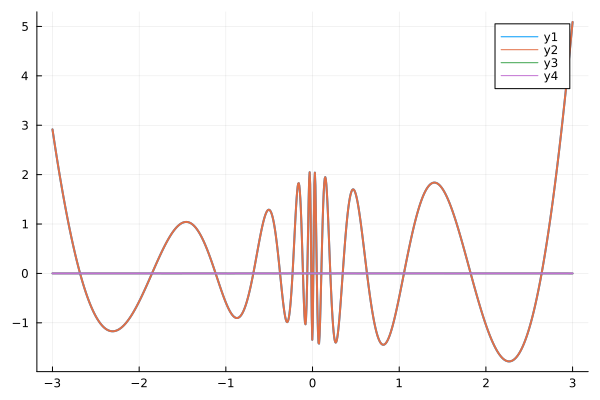

In [27]:
plot(w_mesh, gi[:,1]-gi[:,4], linewidth=2.0)
plot!(w_mesh, gi[:,1]+gi[:,4], linewidth=2.0)
plot!(w_mesh, gi[:,3], linewidth=2.0)
plot!(w_mesh, gi[:,4], linewidth=2.0)

In [26]:

function reshape(rho::Vector{Float64}, cutoff::Float64)
    v_it::Vector{Int} = []
    rho_rep = rho
    sw = true
    for w in 1:length(rho_rep)
        if(rho_rep[w]<0)
            if(sw)
                for it in v_it
                    rho_rep[it] = 0.005                
                end
                empty!(v_it)
                sw = false
            elseif(w<length(rho_rep) && rho_rep[w+1]>0.0)
                sw = true
            end
            rho_rep[w] = 0.005

        elseif(rho_rep[w]<cutoff)
            if(sw)
                push!(v_it,w)
            #elseif(w<length(rho_rep) && rho_rep[w+1]>rho_rep[w])
            #    sw = true
            #    push!(v_it,w)
            end
        elseif(rho_rep[w]>=cutoff && sw)
            empty!(v_it)
            sw = false
        end
        if(w == length(rho_rep))
            if(sw)
                for it in v_it
                    rho_rep[it] = 0.005                
                end
            end
        end
    end
    return rho_rep
end


function KK_GR(w::Vector{Float64}, rho::Vector{Matrix{ComplexF64}})
    #GR_ = zeros(ComplexF64, length(w))
    GR_::Vector{Matrix{ComplexF64}} = []
    dw = w[2]-w[1]
    for w_re in 1:length(w)
        re = zeros(ComplexF64, 2, 2)
        for w_im in 1:length(w)
            if(w_im != w_re)
                re += dw * rho[w_im] / (w[w_re] - w[w_im])
            end 
        end
        ggg = re - 1.0im * rho[w_re] * pi
        push!(GR_, ggg)
    end
    return GR_
end

KK_GR (generic function with 1 method)

In [27]:
g11 = reshape(gi[:,1]+gi[:,4], 0.5)
g22 = reshape(gi[:,1]-gi[:,4], 0.5)
g011 = reshape(g0[:,1]+g0[:,4], 0.5)
g022 = reshape(g0[:,1]-g0[:,4], 0.5)
println("reshape")

500-element Vector{Float64}:
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 ⋮
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005

In [28]:
gi[:,1] = (g11+g22)/2
gi[:,4] = (g11-g22)/2
g0[:,1] = (g011+g022)/2
g0[:,4] = (g011-g022)/2
println("reshape")

reshape


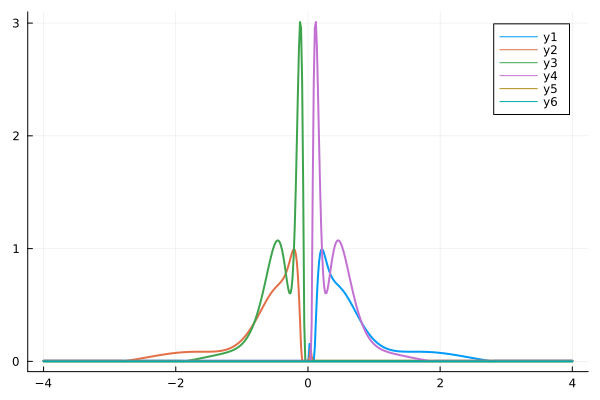

In [30]:
#plot(w_mesh, gi[:,1], linewidth=2.0)
#plot!(w_mesh, gi[:,4], linewidth=2.0)
plot(w_mesh, gi[:,1]-gi[:,4], linewidth=2.0)
plot!(w_mesh, gi[:,1]+gi[:,4], linewidth=2.0)
plot!(w_mesh, g0[:,1]-g0[:,4], linewidth=2.0)
plot!(w_mesh, g0[:,1]+g0[:,4], linewidth=2.0)
plot!(w_mesh, gi[:,2], linewidth=2.0)
plot!(w_mesh, gi[:,3], linewidth=2.0)

In [32]:
function KK_GR_v(w::Vector{Float64}, rho::Matrix{Float64})
    #GR_ = zeros(ComplexF64, length(w))
    GR_ = zeros(ComplexF64, w_num, 4)
    dw = w[2]-w[1]
    for w_re in 1:length(w)
        re = zeros(Float64, 4)
        for w_im in 1:length(w)
            if(w_im != w_re)
                re += dw * rho[w_im,:] / (w[w_re] - w[w_im])
            end 
        end
        GR_[w_re,:] = re - 1.0im*pi* rho[w_re,:]
    end
    return GR_
end

KK_GR_v (generic function with 1 method)

In [33]:
unr_GR_int = KK_GR_v(w_mesh, gi)
unr_GR_0 = KK_GR_v(w_mesh, g0)
println("unrenormed GR")

unrenormed GR


In [35]:
function VtoM(Vec::Matrix{ComplexF64})
    MM::Vector{Matrix{ComplexF64}} = []
    for it in 1:size(Vec)[1]
        Mat = Vec[it,:]' * sigma
        push!(MM, Mat)
    end
    return MM
end

VtoM (generic function with 1 method)

In [36]:
unr_GR_intM = VtoM(unr_GR_int)
unr_GR_0M = VtoM(unr_GR_0)
println("unrenormed GR matrix")

unrenormed GR matrix


In [37]:
function vec_inv(gg::Vector{Matrix{ComplexF64}})
    g_inv::Vector{Matrix{ComplexF64}} = []
    for w in 1:w_num
        push!(g_inv, inv(gg[w]))
    end
    return g_inv
end

vec_inv (generic function with 1 method)

In [41]:
function MtoV(MM::Vector{Matrix{ComplexF64}})
    l = size(MM)[1]
    VV = zeros(ComplexF64, l, 4)
    for it in 1:l
        for mm in 1:4
            VV[it,mm] = tr(sigma[mm]*MM[it])/2
        end
    end
    return VV
end

MtoV (generic function with 1 method)

In [42]:
unr_GR_intM_inv = MtoV(vec_inv(unr_GR_intM))
unr_GR_0M_inv = MtoV(vec_inv(unr_GR_0M))
println("unrenormed GR matrix inv")

unrenormed GR matrix inv


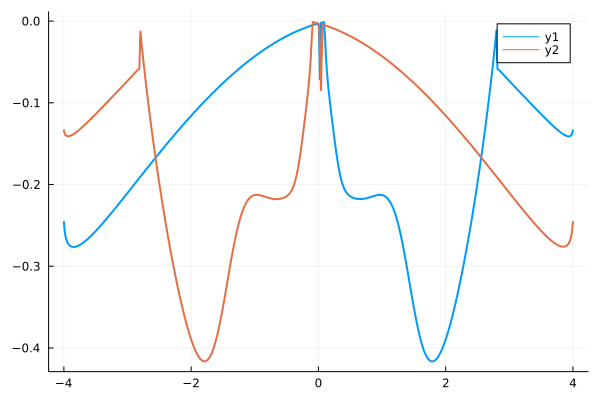

In [61]:
plot(w_mesh, imag.(n_0*(unr_GR_intM_inv[:,1]-unr_GR_intM_inv[:,4])-0*n_int*(unr_GR_0M_inv[:,1]+unr_GR_0M_inv[:,4])), linewidth=2.0)
plot!(w_mesh, imag.(n_0*(unr_GR_intM_inv[:,1]+unr_GR_intM_inv[:,4])-0*n_int*(unr_GR_0M_inv[:,1]-unr_GR_0M_inv[:,4])), linewidth=2.0)
#plot!(w_mesh, n_int*imag.(unr_GR_0M_inv[:,1]-unr_GR_0M_inv[:,4]), linewidth=2.0)
#plot!(w_mesh, n_int*imag.(unr_GR_0M_inv[:,1]+unr_GR_0M_inv[:,4]), linewidth=2.0)

In [44]:
f(beta::Float64, w::Float64) = 1.0/(1.0+exp(beta*w))
function renorm_rho(beta::Float64, w::Vector{Float64}, rho::Vector{Float64})
    n = 0.0
    dw = w[2]-w[1]
    for i in 1:length(w)
        n += dw * rho[i] * f(beta, w[i])
    end
    #rho1 = (0.5/n) * rho
    #return rho1
    return n
end

renorm_rho (generic function with 1 method)

In [45]:
n_int = renorm_rho(irx.beta, w_mesh, gi[:,1])
n_0 = renorm_rho(irx.beta, w_mesh, g0[:,1])
println("n_int:$(n_int), n_0:$(n_0)")

n_int:0.3341293546295631, n_0:0.4569697005527199


In [53]:
function VtoM(Vec::Matrix{Float64})
    MM::Vector{Matrix{ComplexF64}} = []
    for it in 1:size(Vec)[1]
        Mat = Vec[it,:]' * sigma
        push!(MM, Mat)
    end
    return MM
end

VtoM (generic function with 2 methods)

In [54]:
ren_gi = VtoM((0.5/n_int) * gi)
ren_g0 = VtoM((0.5/n_0) * g0)
println("renormed")

renormed


In [55]:
ren_GR_int = KK_GR(w_mesh, ren_gi)
ren_GR_0 = KK_GR(w_mesh, ren_g0)
println(" renormed GR")

 renormed GR


In [56]:
sigma_w::Vector{Matrix{ComplexF64}} = []
for ww in 1:w_num
    if(abs(tr(ren_GR_0[ww]))<1e-4 || abs(tr(ren_GR_int[ww]))<1e-4)
        ss = zeros(ComplexF64, 2, 2)
        push!(sigma_w, ss)
    else
        ss = inv(ren_GR_0[ww]) - inv(ren_GR_int[ww]) - px.mu*Matrix{Complex{Float64}}(I,2,2)
        push!(sigma_w, ss)
    end
end

In [57]:
SR_w = MtoV(sigma_w)
println("sigma_vec")

sigma_vec


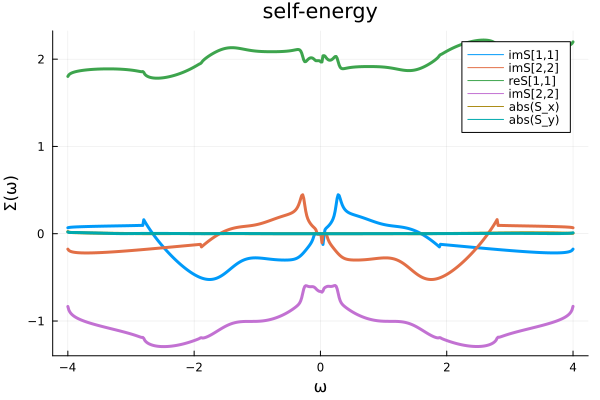

In [58]:
plot(w_mesh, imag.(SR_w[:,1]+ SR_w[:,4]), label="imS[1,1]", linewidth=3.0, xlabel="ω", ylabel="Σ(ω)", title="self-energy")
plot!(w_mesh, imag.(SR_w[:,1]- SR_w[:,4]), label="imS[2,2]", linewidth=3.0)
plot!(w_mesh, real.(SR_w[:,1]), label="reS[1,1]", linewidth=3.0)
plot!(w_mesh, real.(SR_w[:,4]), label="imS[2,2]", linewidth=3.0)
plot!(w_mesh, abs.(SR_w[:,2]), label="abs(S_x)", linewidth=3.0)
plot!(w_mesh, abs.(SR_w[:,3]), label="abs(S_y)", linewidth=3.0)

In [49]:
gi_m = VtoM(gi)
g0_m = VtoM(g0)
println("VtoM G")

500-element Vector{Matrix{ComplexF64}}:
 [0.005470914259737276 + 0.0im 9.205787332789995e-5 - 0.000408968720434251im; 9.205787332789995e-5 + 0.000408968720434251im 0.005470914259737276 + 0.0im]
 [0.005470914259737276 + 0.0im 7.52943064502839e-5 - 0.00031203821056424366im; 7.52943064502839e-5 + 0.00031203821056424366im 0.005470914259737276 + 0.0im]
 [0.005470914259737276 + 0.0im 5.792246383029908e-5 - 0.0002300350395019517im; 5.792246383029908e-5 + 0.0002300350395019517im 0.005470914259737276 + 0.0im]
 [0.005470914259737276 + 0.0im 4.0279812398495845e-5 - 0.0001614641819062426im; 4.0279812398495845e-5 + 0.0001614641819062426im 0.005470914259737276 + 0.0im]
 [0.005470914259737276 + 0.0im 2.2668670705302617e-5 - 0.00010492130529418776im; 2.2668670705302617e-5 + 0.00010492130529418776im 0.005470914259737276 + 0.0im]
 [0.005470914259737276 + 0.0im 5.357826721574732e-6 - 5.909030274521563e-5im; 5.357826721574732e-6 + 5.909030274521563e-5im 0.005470914259737276 + 0.0im]
 [0.005470914259737276

In [50]:
GR_int = KK_GR(w_mesh, gi_m)
GR_0 = KK_GR(w_mesh, g0_m)

500-element Vector{Matrix{ComplexF64}}:
 [-0.254772995776356 - 0.017187384046810267im -0.0013266198105079542 + 0.00017982171203354788im; 0.0012430064448205674 - 0.0007582383891376085im -0.30599974684688147 - 0.017187384046810267im]
 [-0.25009151261748996 - 0.017187384046810267im -0.0008836107764981578 - 0.0003379883655430333im; 0.001076983123397708 - 0.0001350997144596677im -0.30174719960973995 - 0.017187384046810267im]
 [-0.24815139768144143 - 0.017187384046810267im -0.0005521259916413027 - 0.0005214298080711687im; 0.0008932267886938358 + 0.00015749223437699255im -0.30024151066534305 - 0.017187384046810267im]
 [-0.24712907925977098 - 0.017187384046810267im -0.0002896168775616197 - 0.0005750642131502249im; 0.0007248924978274559 + 0.0003219786877120456im -0.29965920394251605 - 0.017187384046810267im]
 [-0.24656871520851073 - 0.017187384046810267im -8.16868852493522e-5 - 0.0005595497142248184im; 0.0005775531185851921 + 0.0004171182555159687im -0.29954453506451423 - 0.017187384046810267im

In [59]:
GR_v_int = KK_GR_v(w_mesh,gi)
GR_v_0 = KK_GR_v(w_mesh,g0) 

500×4 Matrix{ComplexF64}:
 -0.280386-0.0171874im   -4.18067e-5-0.000289208im  …  0.0256134-0.0im
 -0.275919-0.0171874im    9.66862e-5-0.000236544im     0.0258278-0.0im
 -0.274196-0.0171874im    0.00017055-0.000181969im     0.0260451-0.0im
 -0.273394-0.0171874im   0.000217638-0.000126543im     0.0262651-0.0im
 -0.273057-0.0171874im   0.000247933-7.12157e-5im      0.0264879-0.0im
 -0.273002-0.0171874im   0.000265744-1.68321e-5im   …  0.0267136-0.0im
 -0.273138-0.0171874im   0.000273479+3.5864e-5im       0.0269423-0.0im
 -0.273414-0.0171874im   0.000272741+8.62236e-5im       0.027174-0.0im
 -0.273797-0.0171874im   0.000264738+0.000133688im     0.0274087-0.0im
 -0.274266-0.0171874im    0.00025046+0.000177785im     0.0276466-0.0im
 -0.274805-0.0171874im    0.00023077+0.00021812im   …  0.0278876-0.0im
 -0.275403-0.0171874im   0.000206448+0.000254378im     0.0281318-0.0im
 -0.276053-0.0171874im   0.000178212+0.000286312im     0.0283792-0.0im
          ⋮                                        

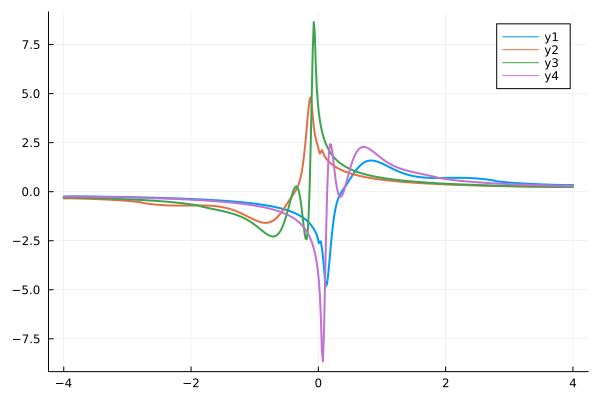

In [71]:
plot(w_mesh, real.(GR_v_int[:,1]-GR_v_int[:,4]), linewidth=2.0)
plot!(w_mesh, real.(GR_v_int[:,1]+GR_v_int[:,4]), linewidth=2.0)
plot!(w_mesh, real.(GR_v_0[:,1]-GR_v_0[:,4]), linewidth=2.0)
plot!(w_mesh, real.(GR_v_0[:,1]+GR_v_0[:,4]), linewidth=2.0)

In [63]:
GR_0 = VtoM(GR_v_0)
GR_int = VtoM(GR_v_int)
println("GR matrix")

500-element Vector{Matrix{ComplexF64}}:
 [-0.3460744677728189 + 0.0235066271671425im 0.00046391149913356804 + 0.0007020381810925322im; -0.0007259653957246951 + 0.00020879300399398372im -0.2546795259341569 + 0.0235066271671425im]
 [-0.3401500972695513 + 0.0235066271671425im 0.000556980733787531 + 0.0003687899977306319im; -0.0003996758171076535 + 0.00039663718440021166im -0.24789801204994238 + 0.0235066271671425im]
 [-0.3379851005005882 + 0.0235066271671425im 0.0005651211856688829 + 0.00017401413691463163im; -0.0001846646334421593 + 0.000438955743359733im -0.24486275346609415 + 0.0235066271671425im]
 [-0.3370856978847854 + 0.0235066271671425im 0.0005451531588170057 + 3.275897395450063e-5im; -2.2230485136141148e-5 + 0.0004242392223646334im -0.24307967434070232 + 0.0235066271671425im]
 [-0.33682871795515784 + 0.0235066271671425im 0.0005112756165931736 - 7.795069474065628e-5im; 0.00010360370756384117 + 0.0003786328028935799im -0.24192529758295486 + 0.0235066271671425im]
 [-0.336965119407636

In [77]:
G0_inv = vec_inv(GR_0)
GR_inv = vec_inv(GR_int)

500-element Vector{Matrix{ComplexF64}}:
 [-2.876269172755912 - 0.19535080607367666im -0.003902880063466188 - 0.00864466745856845im; 0.008453209405606033 - 0.0010209714064036825im -3.893319579100716 - 0.3593274748624125im]
 [-2.925892315917803 - 0.20219899209820313im -0.005765466766882126 - 0.005353763954362108im; 0.005405212663529208 - 0.0038428921472191445im -3.9979512840838476 - 0.3791014559525652im]
 [-2.9444596029751207 - 0.20479161096578605im -0.006345280982342573 - 0.003174291793325169im; 0.0030514778522050473 - 0.004831031739700034im -4.046616097894048 - 0.38848086805094323im]
 [-2.9522451754862242 - 0.20588245173900876im -0.0064497932170244476 - 0.0014833114992327755im; 0.001115322717807168 - 0.005025775432313645im -4.075758595649404 - 0.3941507708186383im]
 [-2.954479901726579 - 0.2061945716974786im -0.006300990746065872 - 9.603599263661067e-5im; -0.0004801318569401893 - 0.0047589558448233905im -4.094849473257724 - 0.39788520070706845im]
 [-2.9532983979973757 - 0.2060265347158

In [79]:
G0_v_inv = MtoV(G0_inv)
GR_v_inv = MtoV(GR_inv)
println("inv_vector")

inv_vector


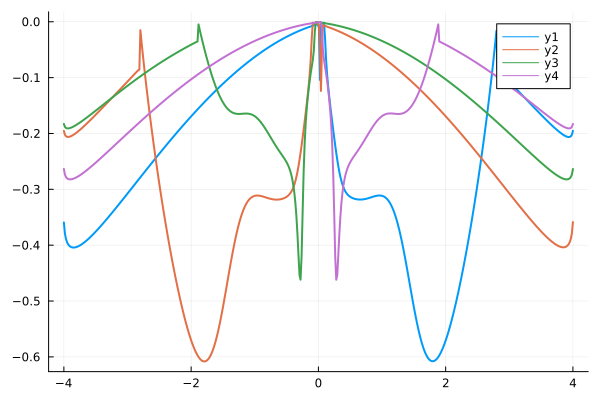

In [81]:
plot(w_mesh, imag.(GR_v_inv[:,1]-GR_v_inv[:,4]), linewidth=2.0)
plot!(w_mesh, imag.(GR_v_inv[:,1]+GR_v_inv[:,4]), linewidth=2.0)
plot!(w_mesh, imag.(G0_v_inv[:,1]-G0_v_inv[:,4]), linewidth=2.0)
plot!(w_mesh, imag.(G0_v_inv[:,1]+G0_v_inv[:,4]), linewidth=2.0)

In [1]:
using Distributed

In [2]:
addprocs(4)

4-element Vector{Int64}:
 2
 3
 4
 5

In [11]:
@everywhere using SharedArrays

In [19]:
a = SharedArray{Float64}(8)

8-element SharedVector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [21]:
@distributed for i in 1:8
    a[i] = 5
end

Task (runnable) @0x000000010f5270f0

In [22]:
a

8-element SharedVector{Float64}:
 5.0
 5.0
 5.0
 5.0
 5.0
 5.0
 5.0
 5.0

In [28]:
z = SharedArray{Float64, 3}(100, 2, 2)

100×2×2 SharedArray{Float64, 3}:
[:, :, 1] =
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 ⋮    
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

[:, :, 2] =
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 ⋮    
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

In [29]:
z[1,:,:]

2×2 Matrix{Float64}:
 0.0  0.0
 0.0  0.0

In [30]:
z[1,:,:] = [2.0 1.0; 2.0 1.0]

2×2 Matrix{Float64}:
 2.0  1.0
 2.0  1.0